In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os

from scipy.stats import zscore

from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [2]:
RUN_PATH = "/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/"
PHENO_PATH = RUN_PATH+"participant_phenotype/"
ID = "2022_07_08_ventile5"
usedtraits = []

# RUN_PATH = sys.argv[1]
# PHENO_PATH = RUN_PATH+"participant_phenotype/"
# ID = sys.argv[2]
# usedtraits = sys.argv[3]

traitsfile = PHENO_PATH+ID+'_corrected_z.csv'
ldscfile = RUN_PATH+"gwas/"+ID+"__FINAL/all_h2.csv"

# FINAL COX
coxfile = RUN_PATH+"diseases_cov/"+ID+"__cox_pval.csv"

# conservative COX
#coxfile = RUN_PATH+"diseases_cov/"+ID+"__cox_with_sbp_dbp_pr_hair_skin_color_pval.csv"


outfile1=RUN_PATH+"participant_phenotype/"+ID+"__corr_h2_disease_1.pdf"
outfile2=RUN_PATH+"participant_phenotype/"+ID+"__corr_h2_disease_2.pdf"

In [126]:
traits=pd.read_csv(traitsfile, index_col=0)
ldsc_full=pd.read_csv(ldscfile, index_col=0)
cox_full=pd.read_csv(coxfile, index_col=0)
cox_full = -cox_full.apply(np.log10)
cox_full = cox_full.loc[sorted(cox.index)]

new = []
for i in traits.columns:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
traits.columns=new

new = []
for i in ldsc_full.index:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
ldsc_full.index=new

new = []
for i in cox_full.columns:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
cox_full.columns=new

# Full Clustermap

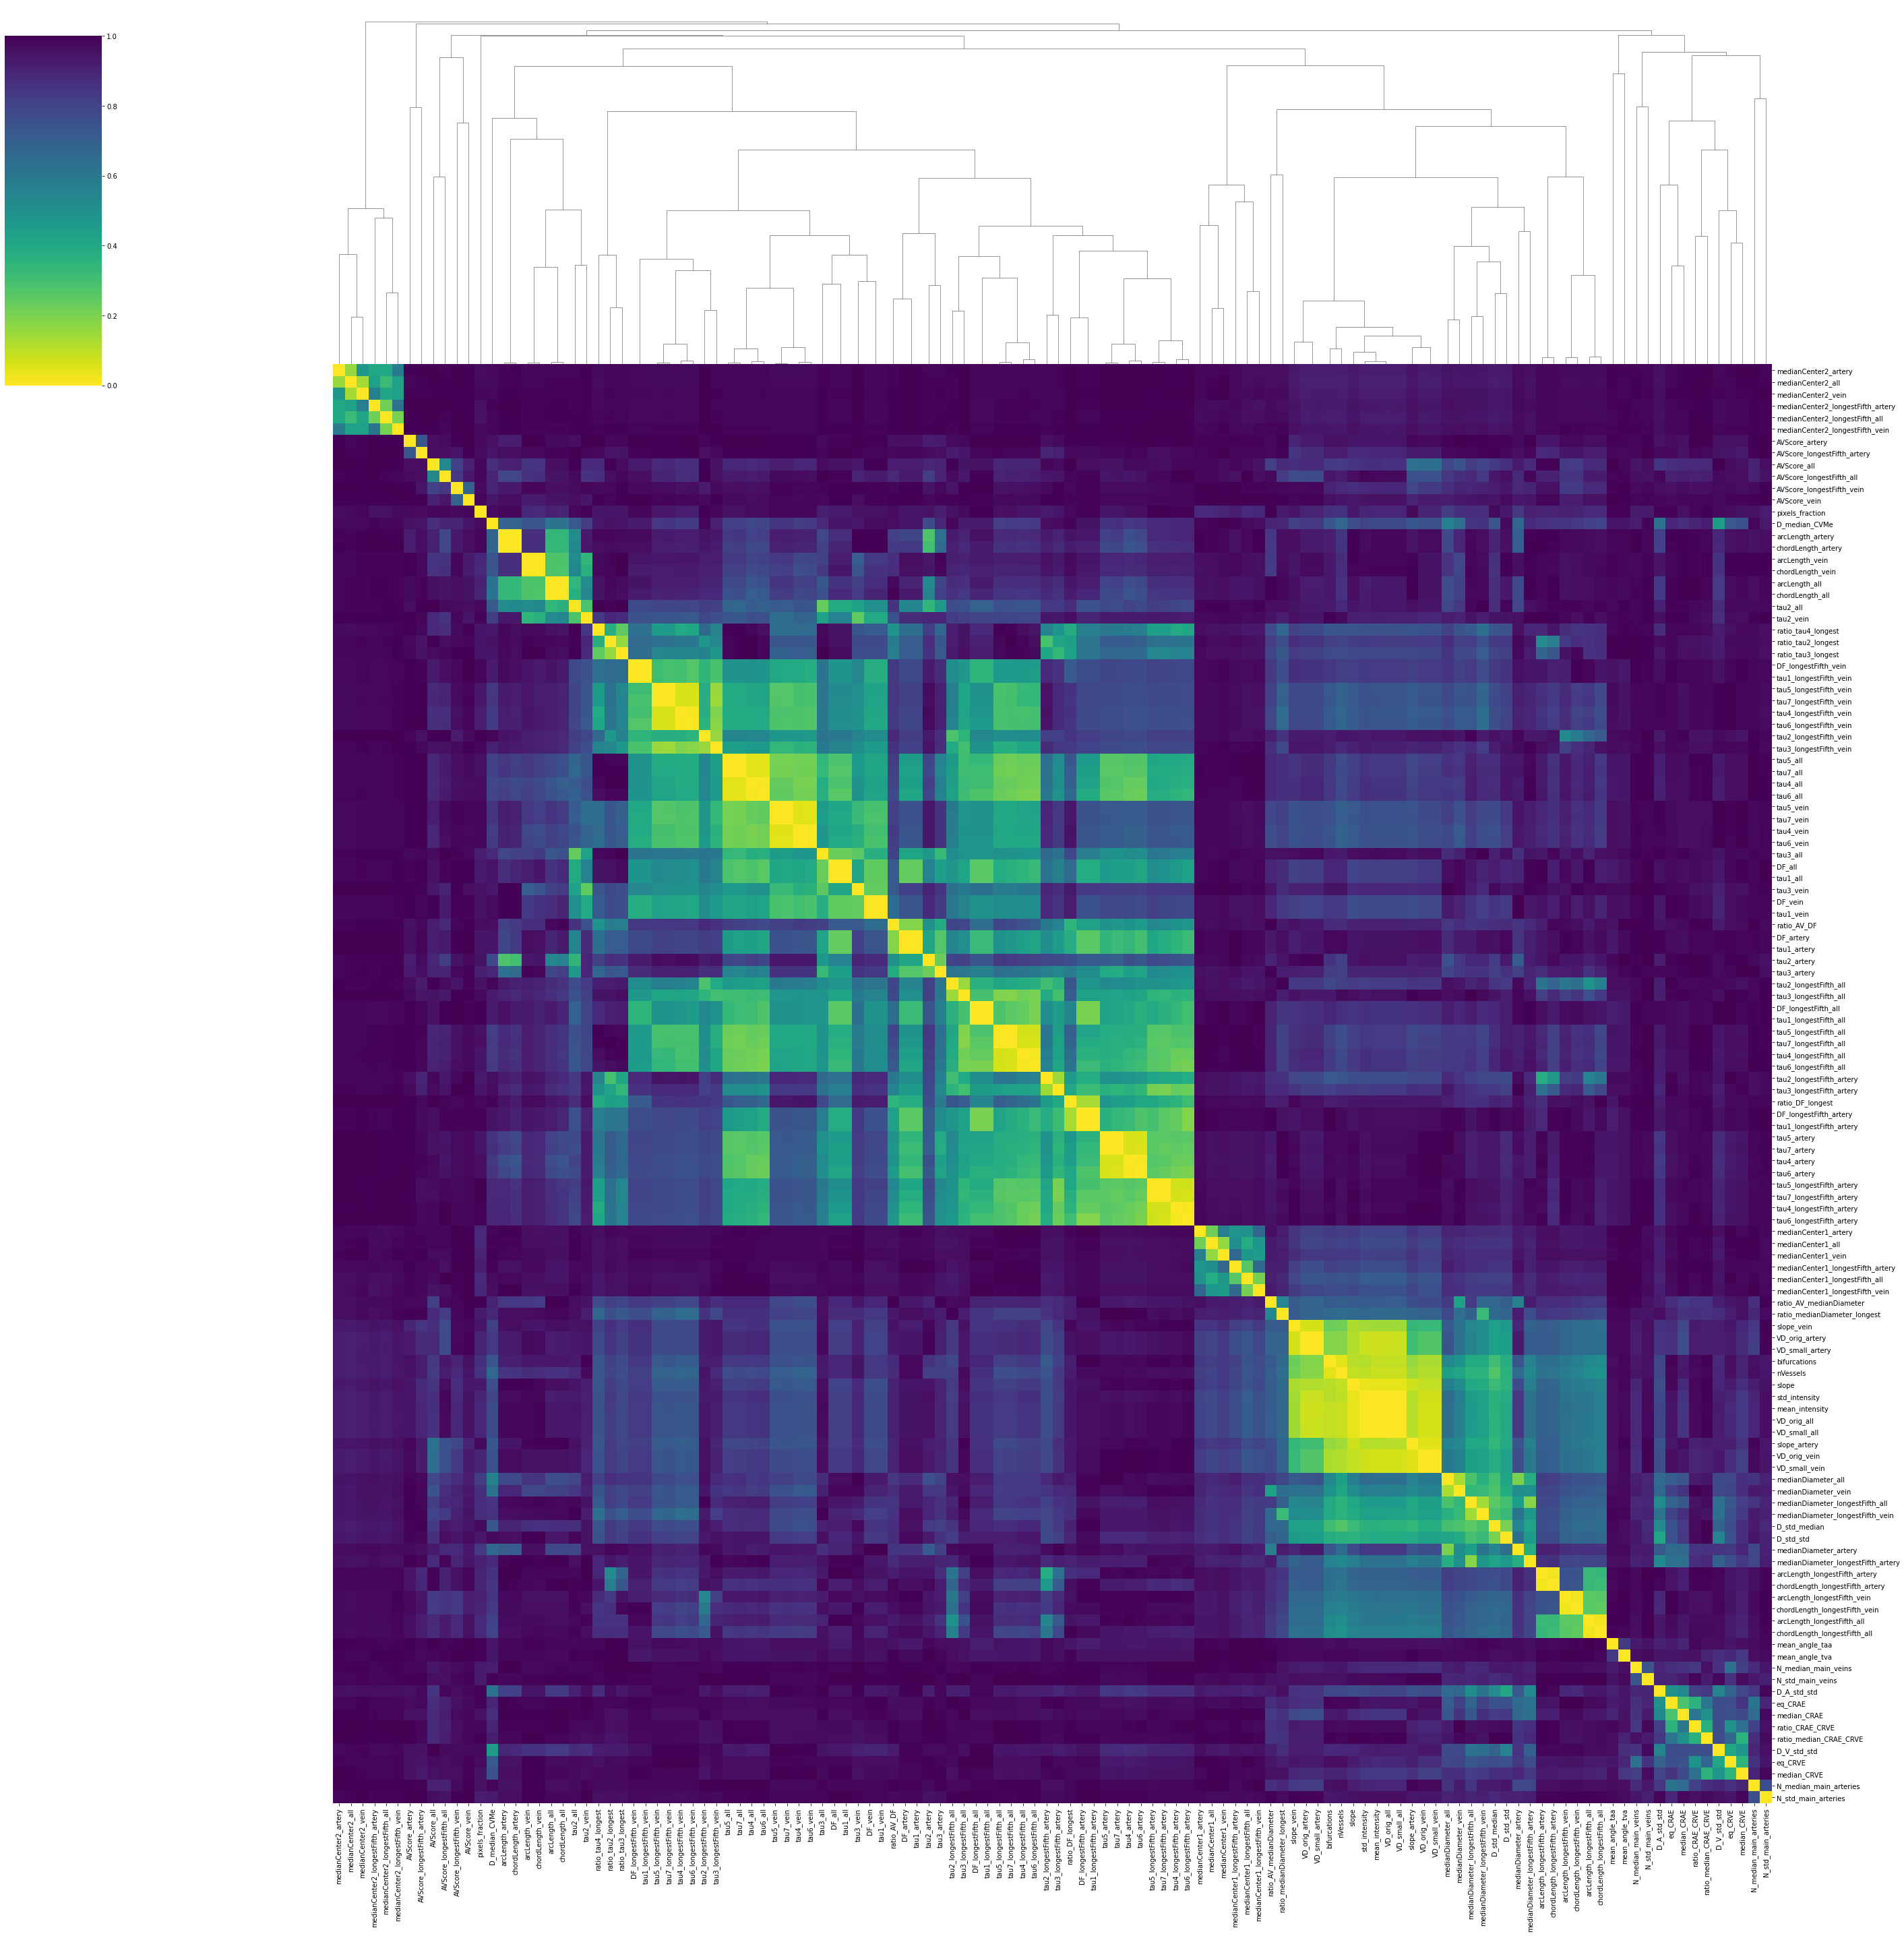

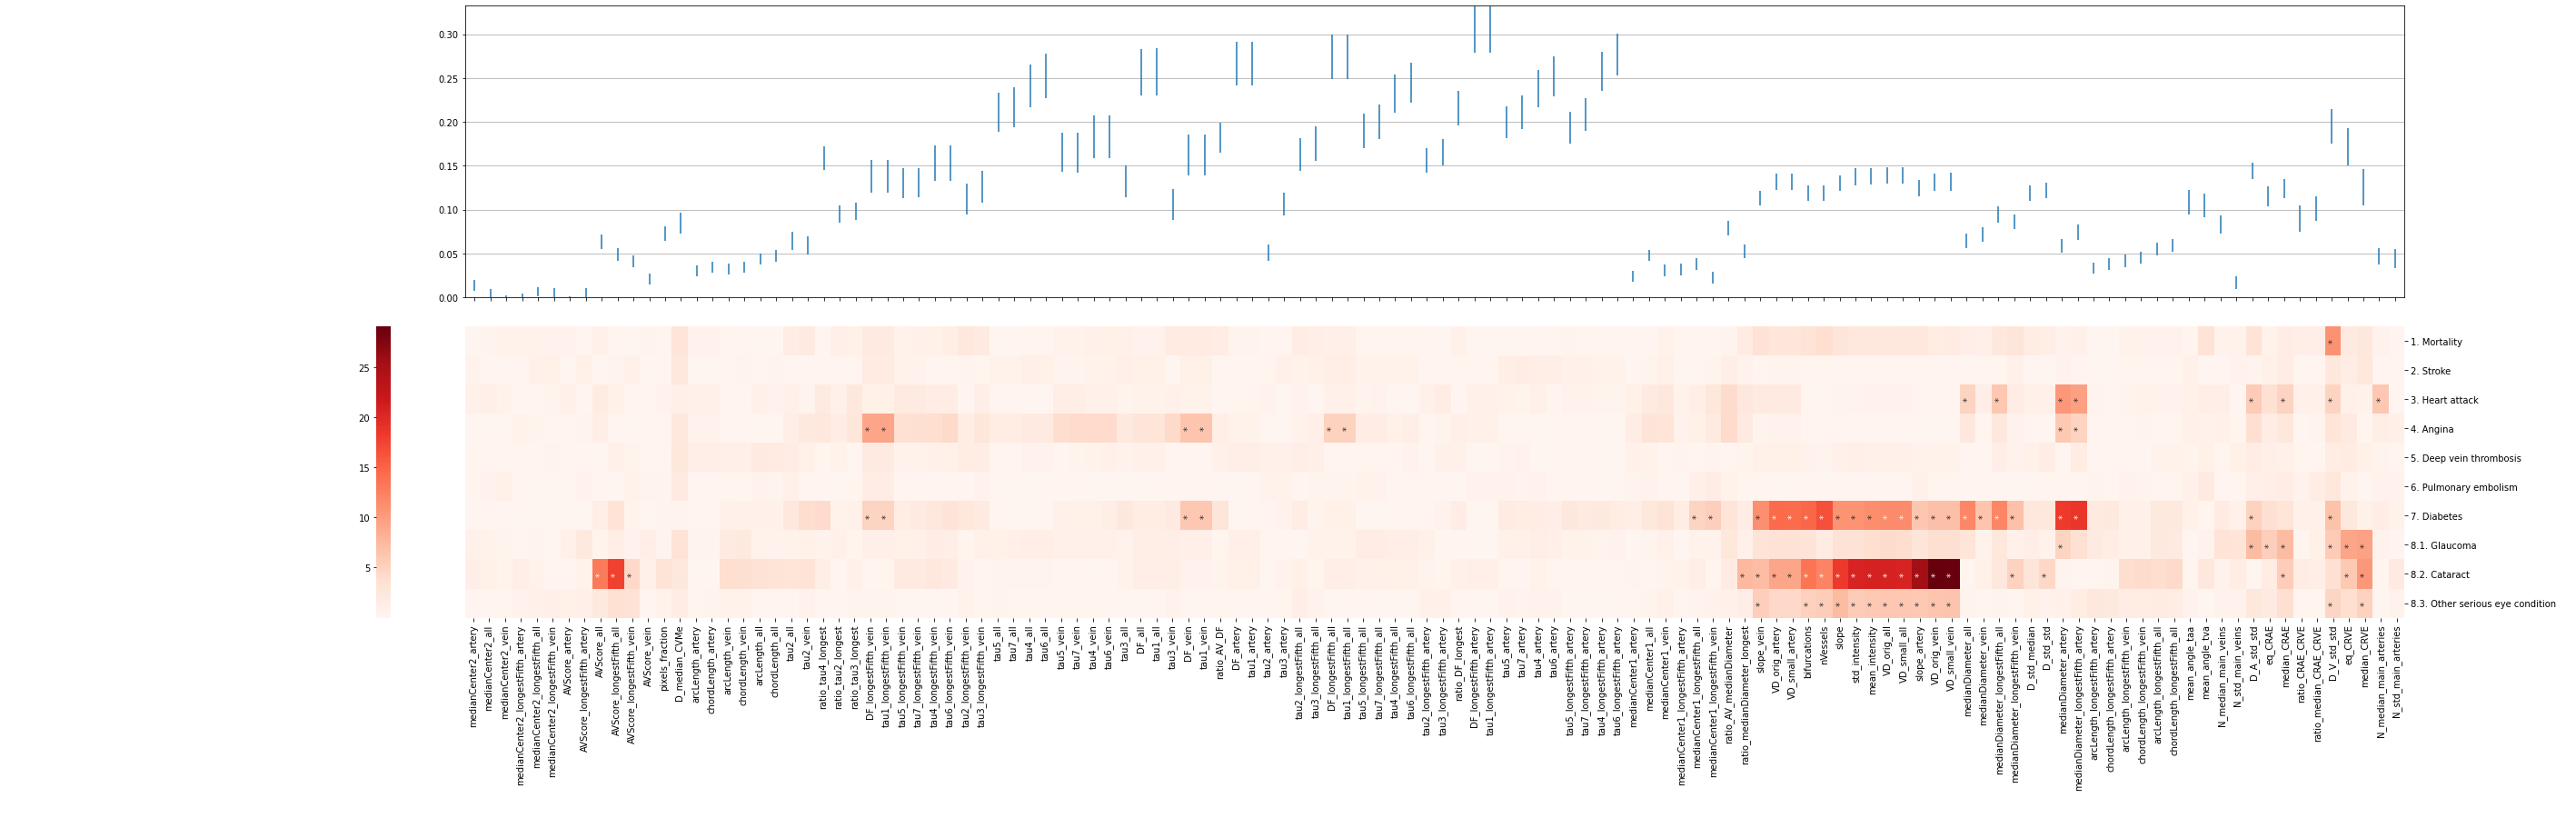

In [77]:
# A: Clustermap

figsize=40

import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

# traits['FUN'] = -traits['VD_orig_all']
usedtraits=[i for i in traits.columns if ((('tau' in i) | ('DF' in i)) & ('longest' in i))]
usedtraits=traits.columns#cluster_traits

# # 1) no type specificity, no longest
# usedtraits=['tau1_all','tau2_all','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all', 'medianCenter1_all', 'medianCenter2_all']

# # 2) add type specificity
# usedtraits=['tau1_all','tau1_artery','tau1_vein','tau2_all','tau2_artery','tau2_vein','tau4_artery','tau4_vein','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all','medianDiameter_artery','medianDiameter_vein',\
#             'medianCenter1_all','medianCenter1_artery','medianCenter1_vein', 'medianCenter2_all',\
#             'medianCenter2_artery','medianCenter2_vein']
# print(usedtraits)

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
hc.cophenet(linkage, sp.distance.squareform(DF_dism))

h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(figsize,figsize), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)

plt.savefig(outfile1)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc_full.loc[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]
cox = cox_full[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

fig, axs = plt.subplots(nrows=3, figsize=(figsize,13), gridspec_kw={'height_ratios': [50, 50, 30]})

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
h_h2=axs[0].errorbar(ldsc.index, ldsc['h2'], ldsc['h2_se'], fmt='', linestyle='')
axs[0].grid(axis='y')
axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
axs[0].set(xticklabels=[])
axs[0].margins(x=0.005*40/figsize)

plt.tight_layout() # needed to match x-axis later

#### C: DISEASE


# Bonferroni Cox significance asterisks


# significant = cox > -np.log10(0.05 / cox.shape[0] / cox.shape[1])

# asterisks = significant.applymap(str)
# asterisks = asterisks.replace('False', "")
# asterisks = asterisks.replace('True', "*")

# significant = cox > -np.log10(0.01 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "**")
# asterisks[significant] = tmp[significant]

# significant = cox > -np.log10(0.001 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "***")
# asterisks[significant] = tmp[significant]


# Benjamini-Hochberg significant


cox_melt = pd.melt(cox.reset_index(), id_vars='index')
cox_melt['rank'] = cox_melt['value'].rank()
cox_melt['bh_threshold'] = -np.log10(0.05 / cox_melt['rank'])
cox_melt['significant'] = cox_melt['value'] > cox_melt['bh_threshold']
significant = cox_melt.pivot(columns='variable', index='index')['significant']

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

asterisks = asterisks[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]



# plot cox heatmap

h_cox=sns.heatmap(data=cox, ax=axs[1], annot=asterisks, fmt='', annot_kws={'rotation': 90}, cbar_kws={'location':'left'}, cmap='Reds')
axs[1].tick_params(axis='y', rotation=0)
axs[1].yaxis.tick_right()


# plt.tight_layout() # needed to match x-axis later


# adjust plot position on X to match cluster

# originals
pos=axs[0].get_position().get_points()
pos_cluster=h.ax_heatmap.get_position().get_points()

# adapt to cluster
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]

# create adjusted bbox object
bbox=axs[0].get_position()
bbox.set_points(pos)

# adapt plot
axs[0].set_position(bbox)


pos=h_cox.get_position().get_points()
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]
bbox=h_cox.get_position()
bbox.set_points(pos)
axs[1].set_position(bbox)

axs[2].axis('off')
plt.savefig(outfile2)

# Basic: No type specificity, no longest

In [86]:
usedtraits=traits.columns.values
removed = [i for i in usedtraits if "DF_" in i]
usedtraits = [i for i in usedtraits if "DF_" not in i]
removed = removed + [i for i in usedtraits if 'longest' in i]
usedtraits = [i for i in usedtraits if 'longest' not in i]

# remove artery-vein except angles, and central diameters; those only exist in artery and vein specific
removed = removed + [i for i in usedtraits if (('artery' in i) | (('vein' in i) & ('veins' not in i)))]
usedtraits = [i for i in usedtraits if (('artery' not in i) & (('vein' not in i) | ('veins' in i)))]
removed = removed + [i for i in usedtraits if (('D_A' in i) | ("D_V" in i))]
usedtraits = [i for i in usedtraits if (('D_A' not in i) & ("D_V" not in i))]

# Sofia proposed to remove
removed = removed + ['pixels_fraction']
usedtraits.remove('pixels_fraction')
removed = removed + ['N_std_main_arteries', "N_std_main_veins"]
usedtraits.remove('N_std_main_arteries')
usedtraits.remove('N_std_main_veins')

# I remove because redundant with VD:
removed = removed + [i for i in usedtraits if "intensity" in i]
usedtraits = [i for i in usedtraits if "intensity" not in i]

# remove remaining ratios
removed = removed + [i for i in usedtraits if 'ratio' in i]
usedtraits = [i for i in usedtraits if 'ratio' not in i]

print('usedtraits', usedtraits, '\n\nremoved', removed)
print(len(usedtraits)+len(removed))

usedtraits ['AVScore_all', 'D_median_CVMe', 'D_std_median', 'D_std_std', 'N_median_main_arteries', 'N_median_main_veins', 'VD_orig_all', 'VD_small_all', 'arcLength_all', 'bifurcations', 'chordLength_all', 'eq_CRAE', 'eq_CRVE', 'mean_angle_taa', 'mean_angle_tva', 'medianCenter1_all', 'medianCenter2_all', 'medianDiameter_all', 'median_CRAE', 'median_CRVE', 'nVessels', 'slope', 'tau1_all', 'tau2_all', 'tau3_all', 'tau4_all', 'tau5_all', 'tau6_all', 'tau7_all'] 

removed ['DF_all', 'DF_artery', 'DF_longestFifth_all', 'DF_longestFifth_artery', 'DF_longestFifth_vein', 'DF_vein', 'ratio_DF_longest', 'AVScore_longestFifth_all', 'AVScore_longestFifth_artery', 'AVScore_longestFifth_vein', 'arcLength_longestFifth_all', 'arcLength_longestFifth_artery', 'arcLength_longestFifth_vein', 'chordLength_longestFifth_all', 'chordLength_longestFifth_artery', 'chordLength_longestFifth_vein', 'medianCenter1_longestFifth_all', 'medianCenter1_longestFifth_artery', 'medianCenter1_longestFifth_vein', 'medianCente

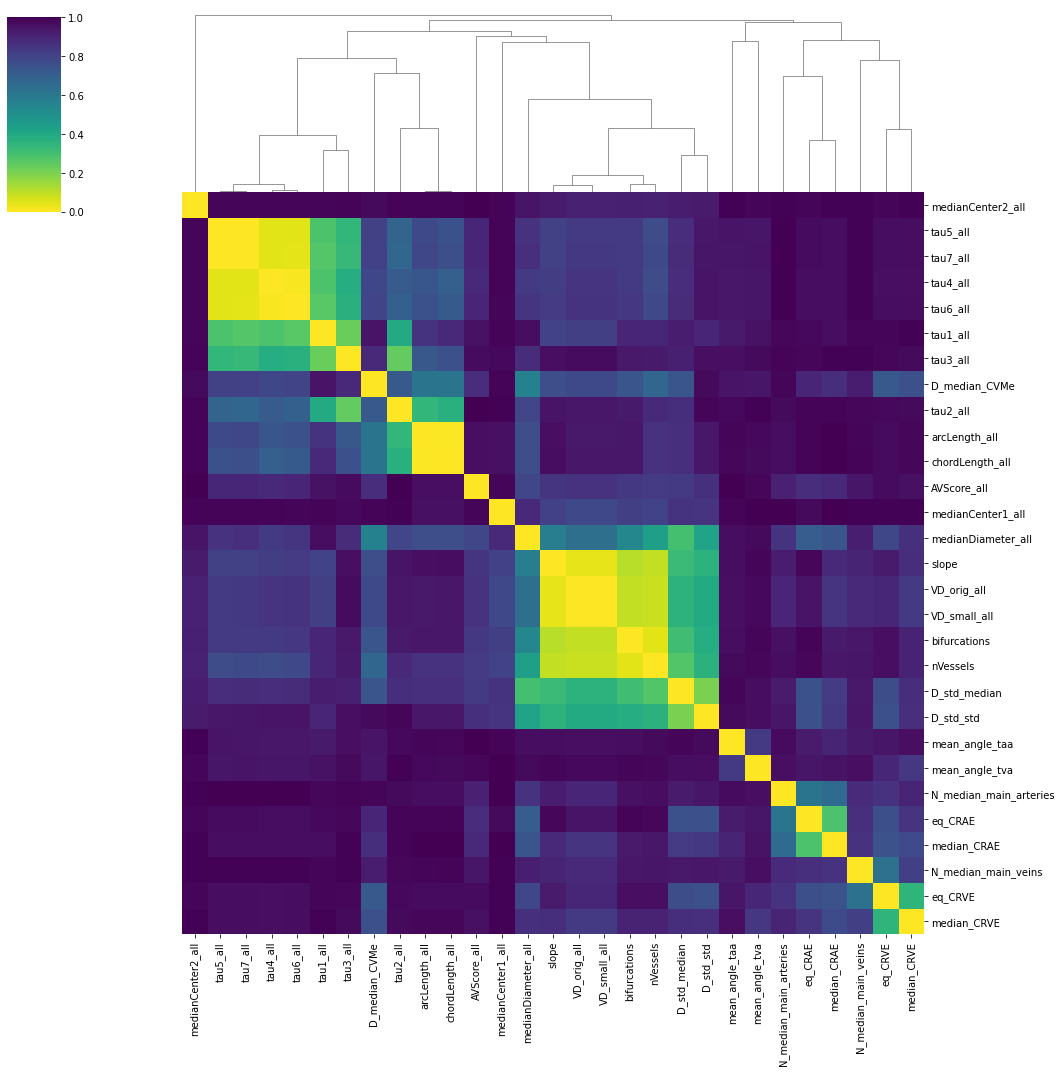

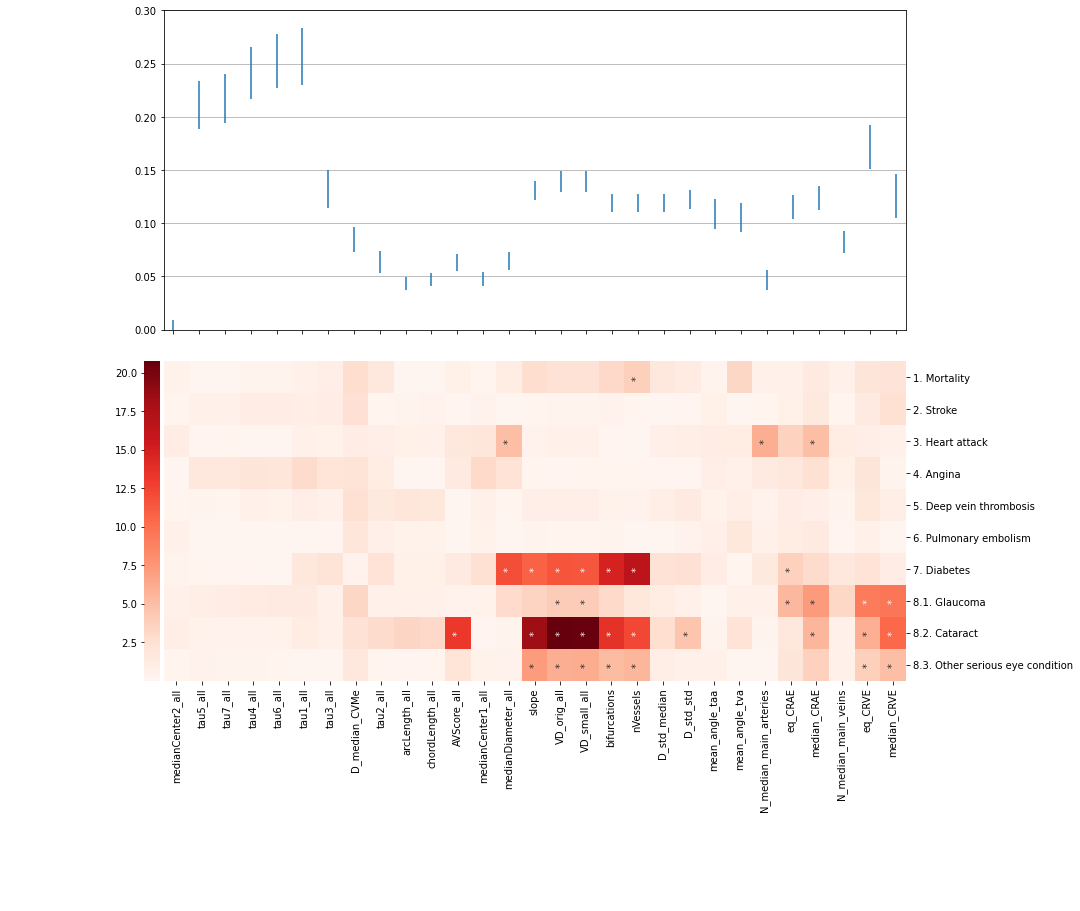

In [87]:
# A: Clustermap


figsize=15

# traits['FUN'] = -traits['VD_orig_all']
# usedtraits=traits.columns#cluster_traits


import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
# # 1) no type specificity, no longest
# usedtraits=['tau1_all','tau2_all','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all', 'medianCenter1_all', 'medianCenter2_all']

# # 2) add type specificity
# usedtraits=['tau1_all','tau1_artery','tau1_vein','tau2_all','tau2_artery','tau2_vein','tau4_artery','tau4_vein','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all','medianDiameter_artery','medianDiameter_vein',\
#             'medianCenter1_all','medianCenter1_artery','medianCenter1_vein', 'medianCenter2_all',\
#             'medianCenter2_artery','medianCenter2_vein']
# print(usedtraits)

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
hc.cophenet(linkage, sp.distance.squareform(DF_dism))

h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(figsize,figsize), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)

plt.savefig(outfile1)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc_full.loc[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]
cox = cox_full[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

fig, axs = plt.subplots(nrows=3, figsize=(figsize,13), gridspec_kw={'height_ratios': [50, 50, 30]})

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
h_h2=axs[0].errorbar(ldsc.index, ldsc['h2'], ldsc['h2_se'], fmt='', linestyle='')
axs[0].grid(axis='y')
axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
axs[0].set(xticklabels=[])
axs[0].margins(x=0.005*40/figsize)

plt.tight_layout() # needed to match x-axis later

#### C: DISEASE


# Bonferroni Cox significance asterisks


# significant = cox > -np.log10(0.05 / cox.shape[0] / cox.shape[1])

# asterisks = significant.applymap(str)
# asterisks = asterisks.replace('False', "")
# asterisks = asterisks.replace('True', "*")

# significant = cox > -np.log10(0.01 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "**")
# asterisks[significant] = tmp[significant]

# significant = cox > -np.log10(0.001 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "***")
# asterisks[significant] = tmp[significant]


# Benjamini-Hochberg significant


cox_melt = pd.melt(cox.reset_index(), id_vars='index')
cox_melt['rank'] = cox_melt['value'].rank()
cox_melt['bh_threshold'] = -np.log10(0.05 / cox_melt['rank'])
cox_melt['significant'] = cox_melt['value'] > cox_melt['bh_threshold']
significant = cox_melt.pivot(columns='variable', index='index')['significant']

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

asterisks = asterisks[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]



# plot cox heatmap

h_cox=sns.heatmap(data=cox, ax=axs[1], annot=asterisks, fmt='', annot_kws={'rotation': 90}, cbar_kws={'location':'left'}, cmap='Reds')
axs[1].tick_params(axis='y', rotation=0)
axs[1].yaxis.tick_right()


# plt.tight_layout() # needed to match x-axis later


# adjust plot position on X to match cluster

# originals
pos=axs[0].get_position().get_points()
pos_cluster=h.ax_heatmap.get_position().get_points()

# adapt to cluster
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]

# create adjusted bbox object
bbox=axs[0].get_position()
bbox.set_points(pos)

# adapt plot
axs[0].set_position(bbox)


pos=h_cox.get_position().get_points()
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]
bbox=h_cox.get_position()
bbox.set_points(pos)
axs[1].set_position(bbox)

axs[2].axis('off')
plt.savefig(outfile2)

### Main clusters

0) Median median vessel position along x axis
1) Temporal angles  
2) Central diameters  
3) Tortuosity / Median deviation from median diameter / total vessel length  
4) AVScore (first proxy for artery-vein vascularization disbalance)  
5) Median median vessel position along y axis  
6) Vascularization / Branching complexity

### Disease associations
2) Central diameters
* Myocardial infarction
* Glaucoma, Cataract, other eye conditions

4) AVScore
* Cataract

6) Vascularization
* Mortality
* Diabetes
* Eye conditions (especially cataract)

Comment: medianDiameter is associated with myocardial infarction. Though it is clustered with vascularization, it is also correlated with central diameters, Seems likely to be a diameter signal because other vascularization parameters do not pick up myocardial infarction.

# Adding type specificity, no 'longest'

In [127]:
usedtraits=traits.columns.values
removed = [i for i in usedtraits if "DF_" in i]
usedtraits = [i for i in usedtraits if "DF_" not in i]
removed = removed + [i for i in usedtraits if 'longest' in i]
usedtraits = [i for i in usedtraits if 'longest' not in i]

# remove artery-vein except angles, and central diameters; those only exist in artery and vein specific
# removed = removed + [i for i in usedtraits if (('artery' in i) | (('vein' in i) & ('veins' not in i)))]
# usedtraits = [i for i in usedtraits if (('artery' not in i) & (('vein' not in i) | ('veins' in i)))]
# removed = removed + [i for i in usedtraits if (('D_A' in i) | ("D_V" in i))]
# usedtraits = [i for i in usedtraits if (('D_A' not in i) & ("D_V" not in i))]

# Sofia proposed to remove
removed = removed + ['pixels_fraction']
usedtraits.remove('pixels_fraction')
removed = removed + ['N_std_main_arteries', "N_std_main_veins"]
usedtraits.remove('N_std_main_arteries')
usedtraits.remove('N_std_main_veins')

# I remove because redundant with VD:
removed = removed + [i for i in usedtraits if "intensity" in i]
usedtraits = [i for i in usedtraits if "intensity" not in i]
removed = removed + [i for i in usedtraits if "VD_small" in i]
usedtraits = [i for i in usedtraits if "VD_small" not in i]
remove_rest = ['AVScore_artery', 'AVScore_vein']
removed = removed + remove_av
for i in remove_av:
    usedtraits.remove(i)
# remove remaining ratios
# removed = removed + [i for i in usedtraits if 'ratio' in i]
# usedtraits = [i for i in usedtraits if 'ratio' not in i]

print('usedtraits', usedtraits, '\n\nremoved', removed)
print(len(usedtraits)+len(removed))

usedtraits ['AVScore_all', 'D_A_std_std', 'D_V_std_std', 'D_median_CVMe', 'D_std_median', 'D_std_std', 'N_median_main_arteries', 'N_median_main_veins', 'VD_orig_all', 'VD_orig_artery', 'VD_orig_vein', 'arcLength_all', 'arcLength_artery', 'arcLength_vein', 'bifurcations', 'chordLength_all', 'chordLength_artery', 'chordLength_vein', 'eq_CRAE', 'eq_CRVE', 'mean_angle_taa', 'mean_angle_tva', 'medianCenter1_all', 'medianCenter1_artery', 'medianCenter1_vein', 'medianCenter2_all', 'medianCenter2_artery', 'medianCenter2_vein', 'medianDiameter_all', 'medianDiameter_artery', 'medianDiameter_vein', 'median_CRAE', 'median_CRVE', 'nVessels', 'ratio_AV_DF', 'ratio_AV_medianDiameter', 'ratio_CRAE_CRVE', 'ratio_median_CRAE_CRVE', 'slope', 'slope_artery', 'slope_vein', 'tau1_all', 'tau1_artery', 'tau1_vein', 'tau2_all', 'tau2_artery', 'tau2_vein', 'tau3_all', 'tau3_artery', 'tau3_vein', 'tau4_all', 'tau4_artery', 'tau4_vein', 'tau5_all', 'tau5_artery', 'tau5_vein', 'tau6_all', 'tau6_artery', 'tau6_vein

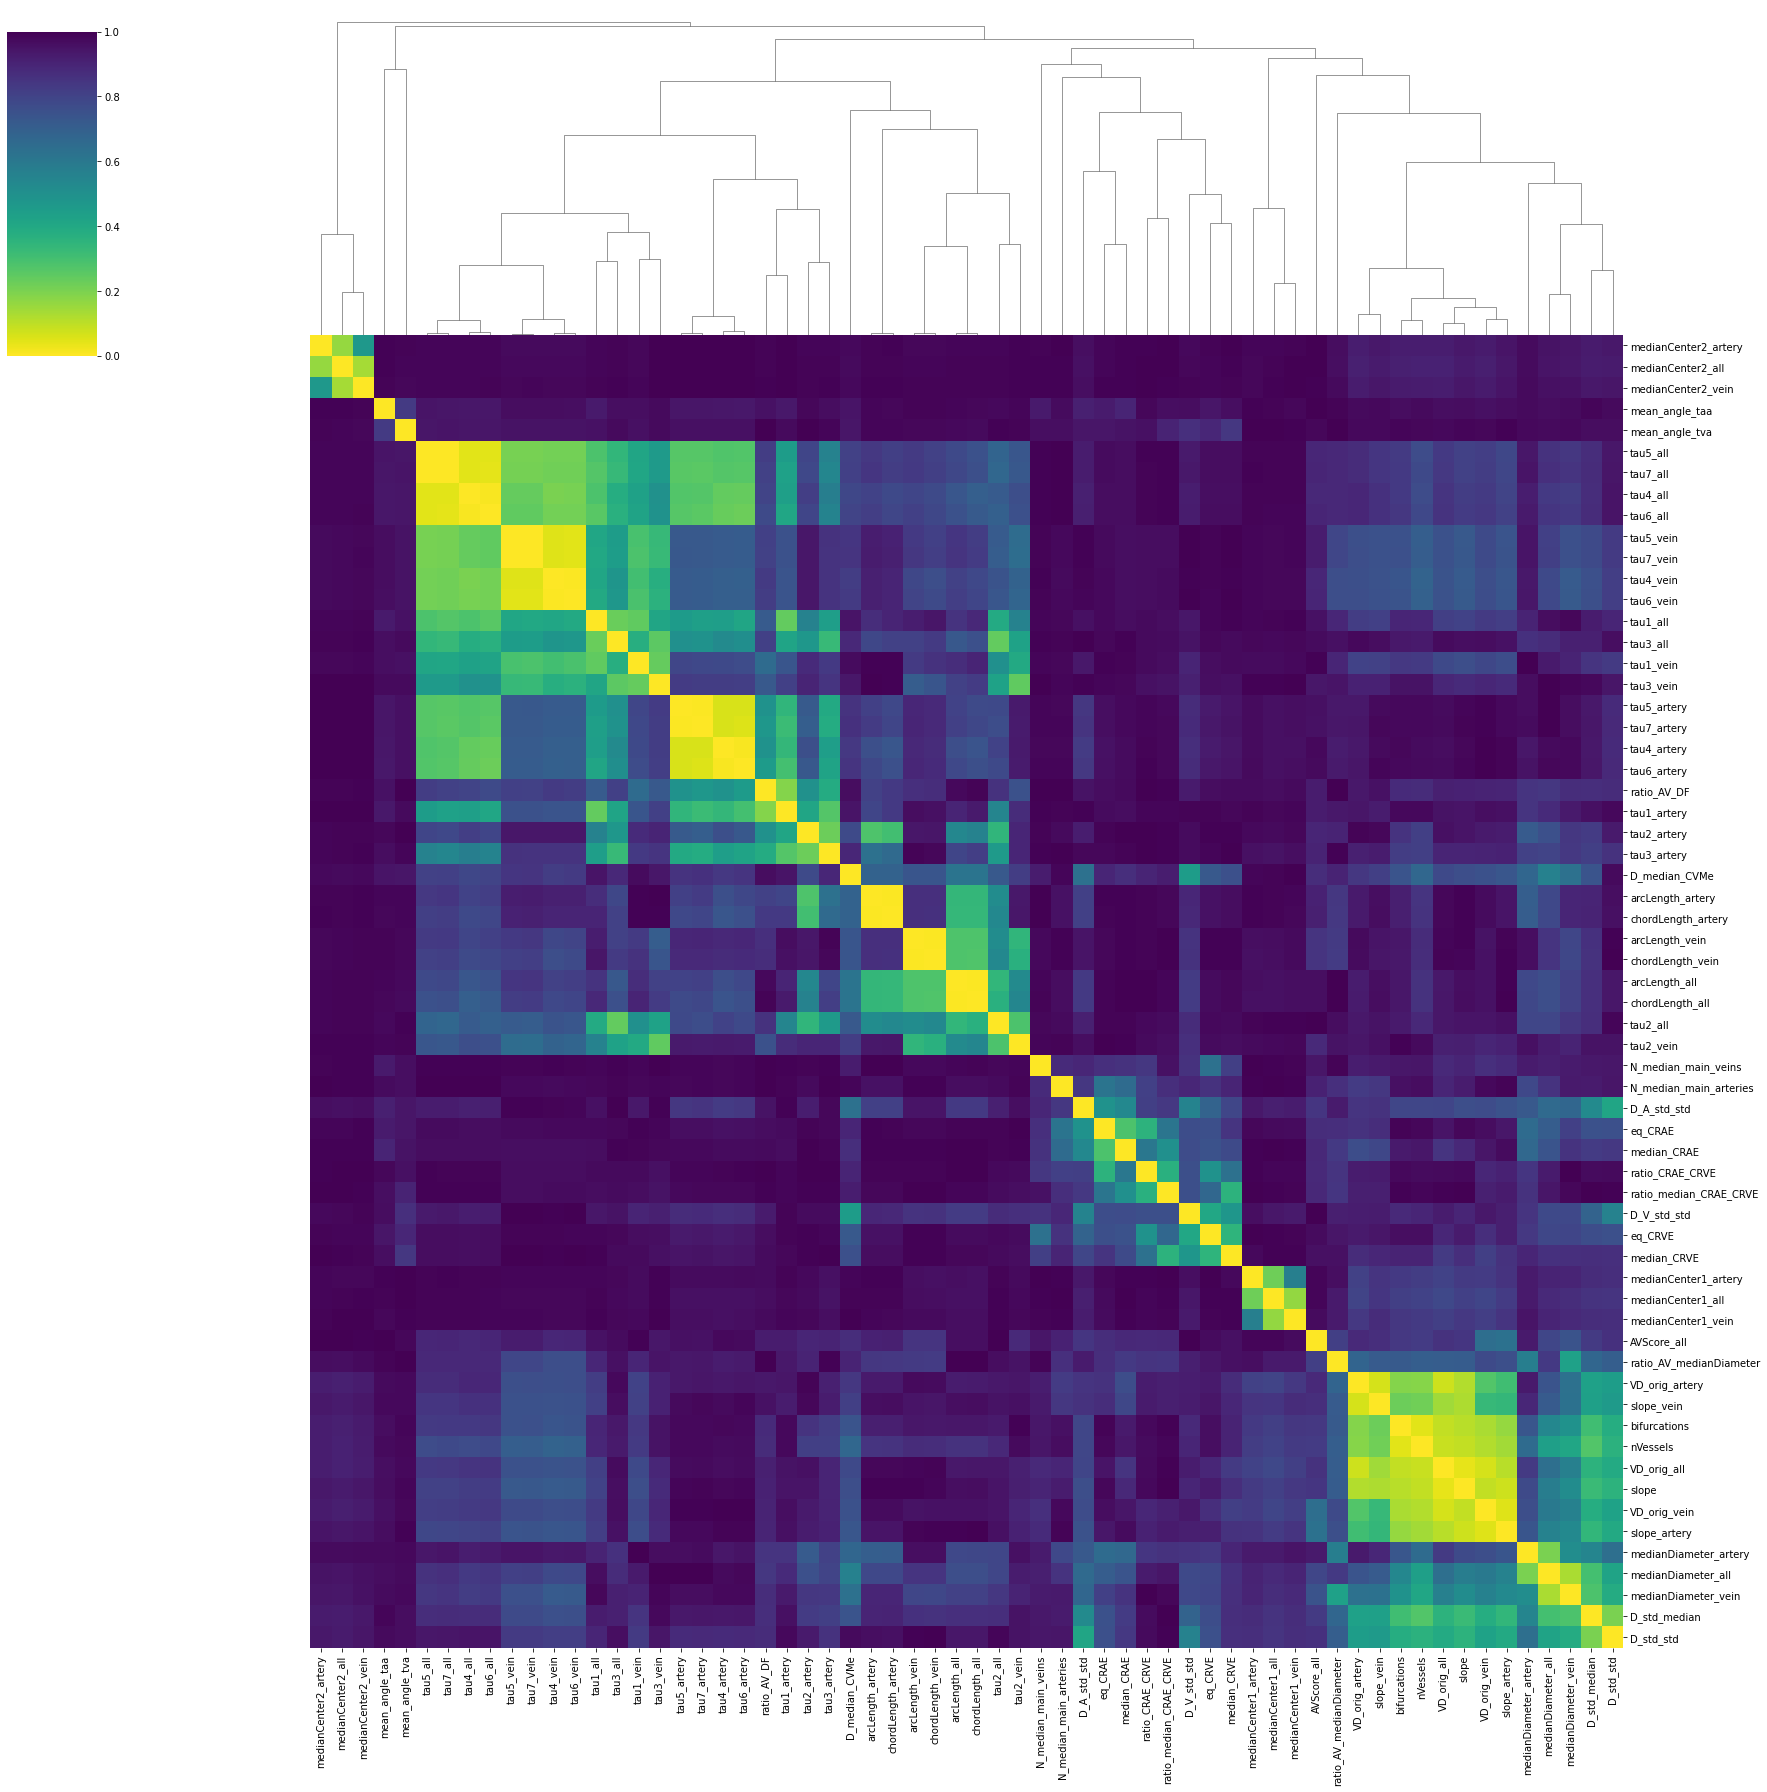

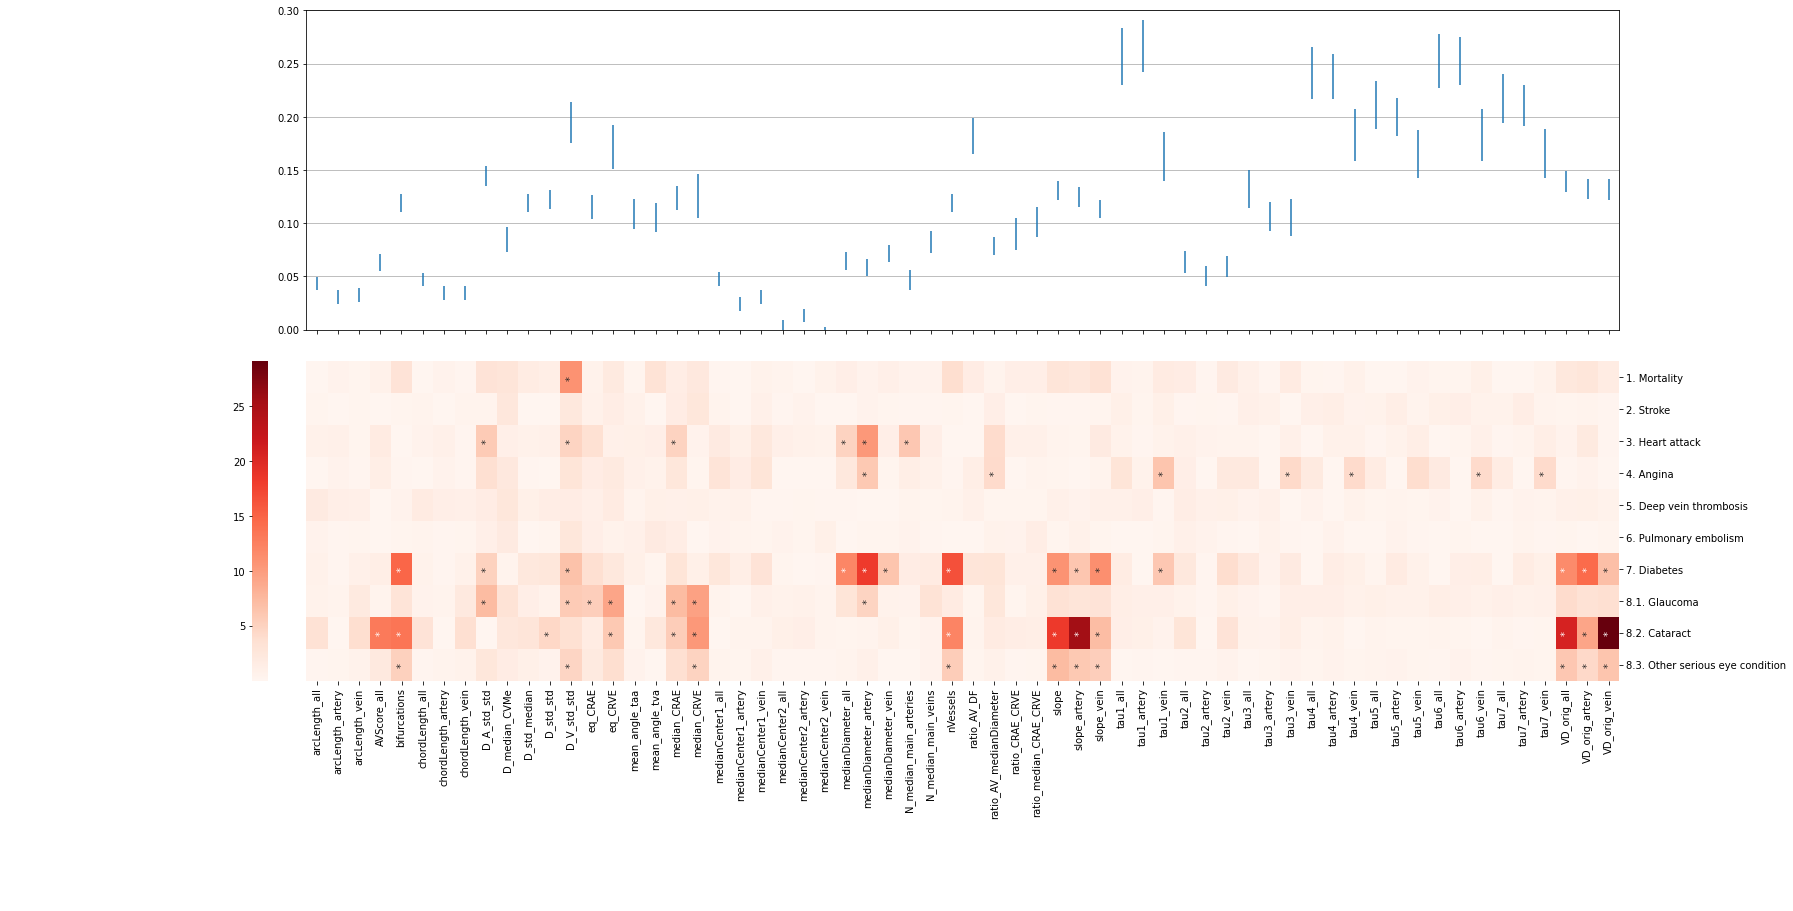

In [128]:
# A: Clustermap


figsize=25

# traits['FUN'] = -traits['VD_orig_all']
# usedtraits=traits.columns#cluster_traits


import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
# # 1) no type specificity, no longest
# usedtraits=['tau1_all','tau2_all','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all', 'medianCenter1_all', 'medianCenter2_all']

# # 2) add type specificity
# usedtraits=['tau1_all','tau1_artery','tau1_vein','tau2_all','tau2_artery','tau2_vein','tau4_artery','tau4_vein','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all','medianDiameter_artery','medianDiameter_vein',\
#             'medianCenter1_all','medianCenter1_artery','medianCenter1_vein', 'medianCenter2_all',\
#             'medianCenter2_artery','medianCenter2_vein']
# print(usedtraits)

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
hc.cophenet(linkage, sp.distance.squareform(DF_dism))

h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(figsize,figsize), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)

plt.savefig(outfile1)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
order = h.dendrogram_row.reordered_ind
order = sorted(usedtraits, key=str.casefold)

ldsc = ldsc_full.loc[order]
cox = cox_full[order]

#### B: HERITABILITY

fig, axs = plt.subplots(nrows=3, figsize=(figsize,13), gridspec_kw={'height_ratios': [50, 50, 30]})

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
h_h2=axs[0].errorbar(ldsc.index, ldsc['h2'], ldsc['h2_se'], fmt='', linestyle='')
axs[0].grid(axis='y')
axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
axs[0].set(xticklabels=[])
axs[0].margins(x=0.005*40/figsize)

plt.tight_layout() # needed to match x-axis later

#### C: DISEASE


# Bonferroni Cox significance asterisks


# significant = cox > -np.log10(0.05 / cox.shape[0] / cox.shape[1])

# asterisks = significant.applymap(str)
# asterisks = asterisks.replace('False', "")
# asterisks = asterisks.replace('True', "*")

# significant = cox > -np.log10(0.01 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "**")
# asterisks[significant] = tmp[significant]

# significant = cox > -np.log10(0.001 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "***")
# asterisks[significant] = tmp[significant]


# Benjamini-Hochberg significant


cox_melt = pd.melt(cox.reset_index(), id_vars='index')
cox_melt['rank'] = cox_melt['value'].rank()
cox_melt['bh_threshold'] = -np.log10(0.05 / cox_melt['rank'])
cox_melt['significant'] = cox_melt['value'] > cox_melt['bh_threshold']
significant = cox_melt.pivot(columns='variable', index='index')['significant']

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

asterisks = asterisks[order]



# plot cox heatmap

h_cox=sns.heatmap(data=cox, ax=axs[1], annot=asterisks, fmt='', annot_kws={'rotation': 90}, cbar_kws={'location':'left'}, cmap='Reds')
axs[1].tick_params(axis='y', rotation=0)
axs[1].yaxis.tick_right()


# plt.tight_layout() # needed to match x-axis later


# adjust plot position on X to match cluster

# originals
pos=axs[0].get_position().get_points()
pos_cluster=h.ax_heatmap.get_position().get_points()

# adapt to cluster
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]

# create adjusted bbox object
bbox=axs[0].get_position()
bbox.set_points(pos)

# adapt plot
axs[0].set_position(bbox)


pos=h_cox.get_position().get_points()
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]
bbox=h_cox.get_position()
bbox.set_points(pos)
axs[1].set_position(bbox)

axs[2].axis('off')
plt.savefig(outfile2)

### Main clusters

0) Median median vessel position along x axis
1) Temporal angles  
2) Central diameters  m
3) Tortuosity / Median deviation from median diameter / total vessel length  
4) AVScore (first proxy for artery-vein vascularization disbalance)  
5) Median median vessel position along y axis  
6) Vascularization / Branching complexity

### Hypotheses

1) Vessel morphology is typeless -> false... for many reasons:
- phenotypic correlations of temporal angles,CRAE/CRVE are low
- various disease associations are type specific, such as antina to tau_vein, etc
- heritability of central venular diameter is significantly higher, for tortuosity it's arterial tortuosity with significantly higher heritability

2) There are type-specific associations -> true
- tortuosity - angina association is specific to veins
- D_V_std - mortality association specific to veins (tbd)

3) Heritability is generally higher in arteries -> false
- In central diameters, veins are more heritable

4) Combining vessel types can lead to higher heritability or novel disease associations -> false
- Combining types never leads to significantly higher heritability or novel disease associations



### Disease associations
2) Central diameters
* Myocardial infarction (signal stronger to specific in arteries)
* Glaucoma, Cataract, other eye conditions
* **Mortality**

3) Tortuosity
* veins <-> angina
* tau1_vein <-> diabetes

4) AVScore
* Cataract

6) Vascularization
* ~~Mortality~~
* Diabetes
* Eye conditions (especially cataract)

# Adding longest segments

In [129]:
usedtraits=traits.columns.values
removed = [i for i in usedtraits if "DF_" in i]
usedtraits = [i for i in usedtraits if "DF_" not in i]
# removed = removed + [i for i in usedtraits if 'longest' in i]
# usedtraits = [i for i in usedtraits if 'longest' not in i]

# remove artery-vein except angles, and central diameters; those only exist in artery and vein specific
# removed = removed + [i for i in usedtraits if (('artery' in i) | (('vein' in i) & ('veins' not in i)))]
# usedtraits = [i for i in usedtraits if (('artery' not in i) & (('vein' not in i) | ('veins' in i)))]
# removed = removed + [i for i in usedtraits if (('D_A' in i) | ("D_V" in i))]
# usedtraits = [i for i in usedtraits if (('D_A' not in i) & ("D_V" not in i))]

# Sofia proposed to remove
removed = removed + ['pixels_fraction']
usedtraits.remove('pixels_fraction')
removed = removed + ['N_std_main_arteries', "N_std_main_veins"]
usedtraits.remove('N_std_main_arteries')
usedtraits.remove('N_std_main_veins')

# I remove because redundant with VD:
removed = removed + [i for i in usedtraits if "intensity" in i]
usedtraits = [i for i in usedtraits if "intensity" not in i]
removed = removed + [i for i in usedtraits if "VD_small" in i]
usedtraits = [i for i in usedtraits if "VD_small" not in i]
remove_rest = ['AVScore_artery', 'AVScore_vein']
removed = removed + remove_av
for i in remove_av:
    usedtraits.remove(i)
# remove remaining ratios
# removed = removed + [i for i in usedtraits if 'ratio' in i]
# usedtraits = [i for i in usedtraits if 'ratio' not in i]

print('usedtraits', usedtraits, '\n\nremoved', removed)
print(len(usedtraits)+len(removed))

usedtraits ['AVScore_all', 'AVScore_all_longestFifth', 'AVScore_artery_longestFifth', 'AVScore_vein_longestFifth', 'D_A_std_std', 'D_V_std_std', 'D_median_CVMe', 'D_std_median', 'D_std_std', 'N_median_main_arteries', 'N_median_main_veins', 'VD_orig_all', 'VD_orig_artery', 'VD_orig_vein', 'arcLength_all', 'arcLength_artery', 'arcLength_all_longestFifth', 'arcLength_artery_longestFifth', 'arcLength_vein_longestFifth', 'arcLength_vein', 'bifurcations', 'chordLength_all', 'chordLength_artery', 'chordLength_all_longestFifth', 'chordLength_artery_longestFifth', 'chordLength_vein_longestFifth', 'chordLength_vein', 'eq_CRAE', 'eq_CRVE', 'mean_angle_taa', 'mean_angle_tva', 'medianCenter1_all', 'medianCenter1_artery', 'medianCenter1_all_longestFifth', 'medianCenter1_artery_longestFifth', 'medianCenter1_vein_longestFifth', 'medianCenter1_vein', 'medianCenter2_all', 'medianCenter2_artery', 'medianCenter2_all_longestFifth', 'medianCenter2_artery_longestFifth', 'medianCenter2_vein_longestFifth', 'me

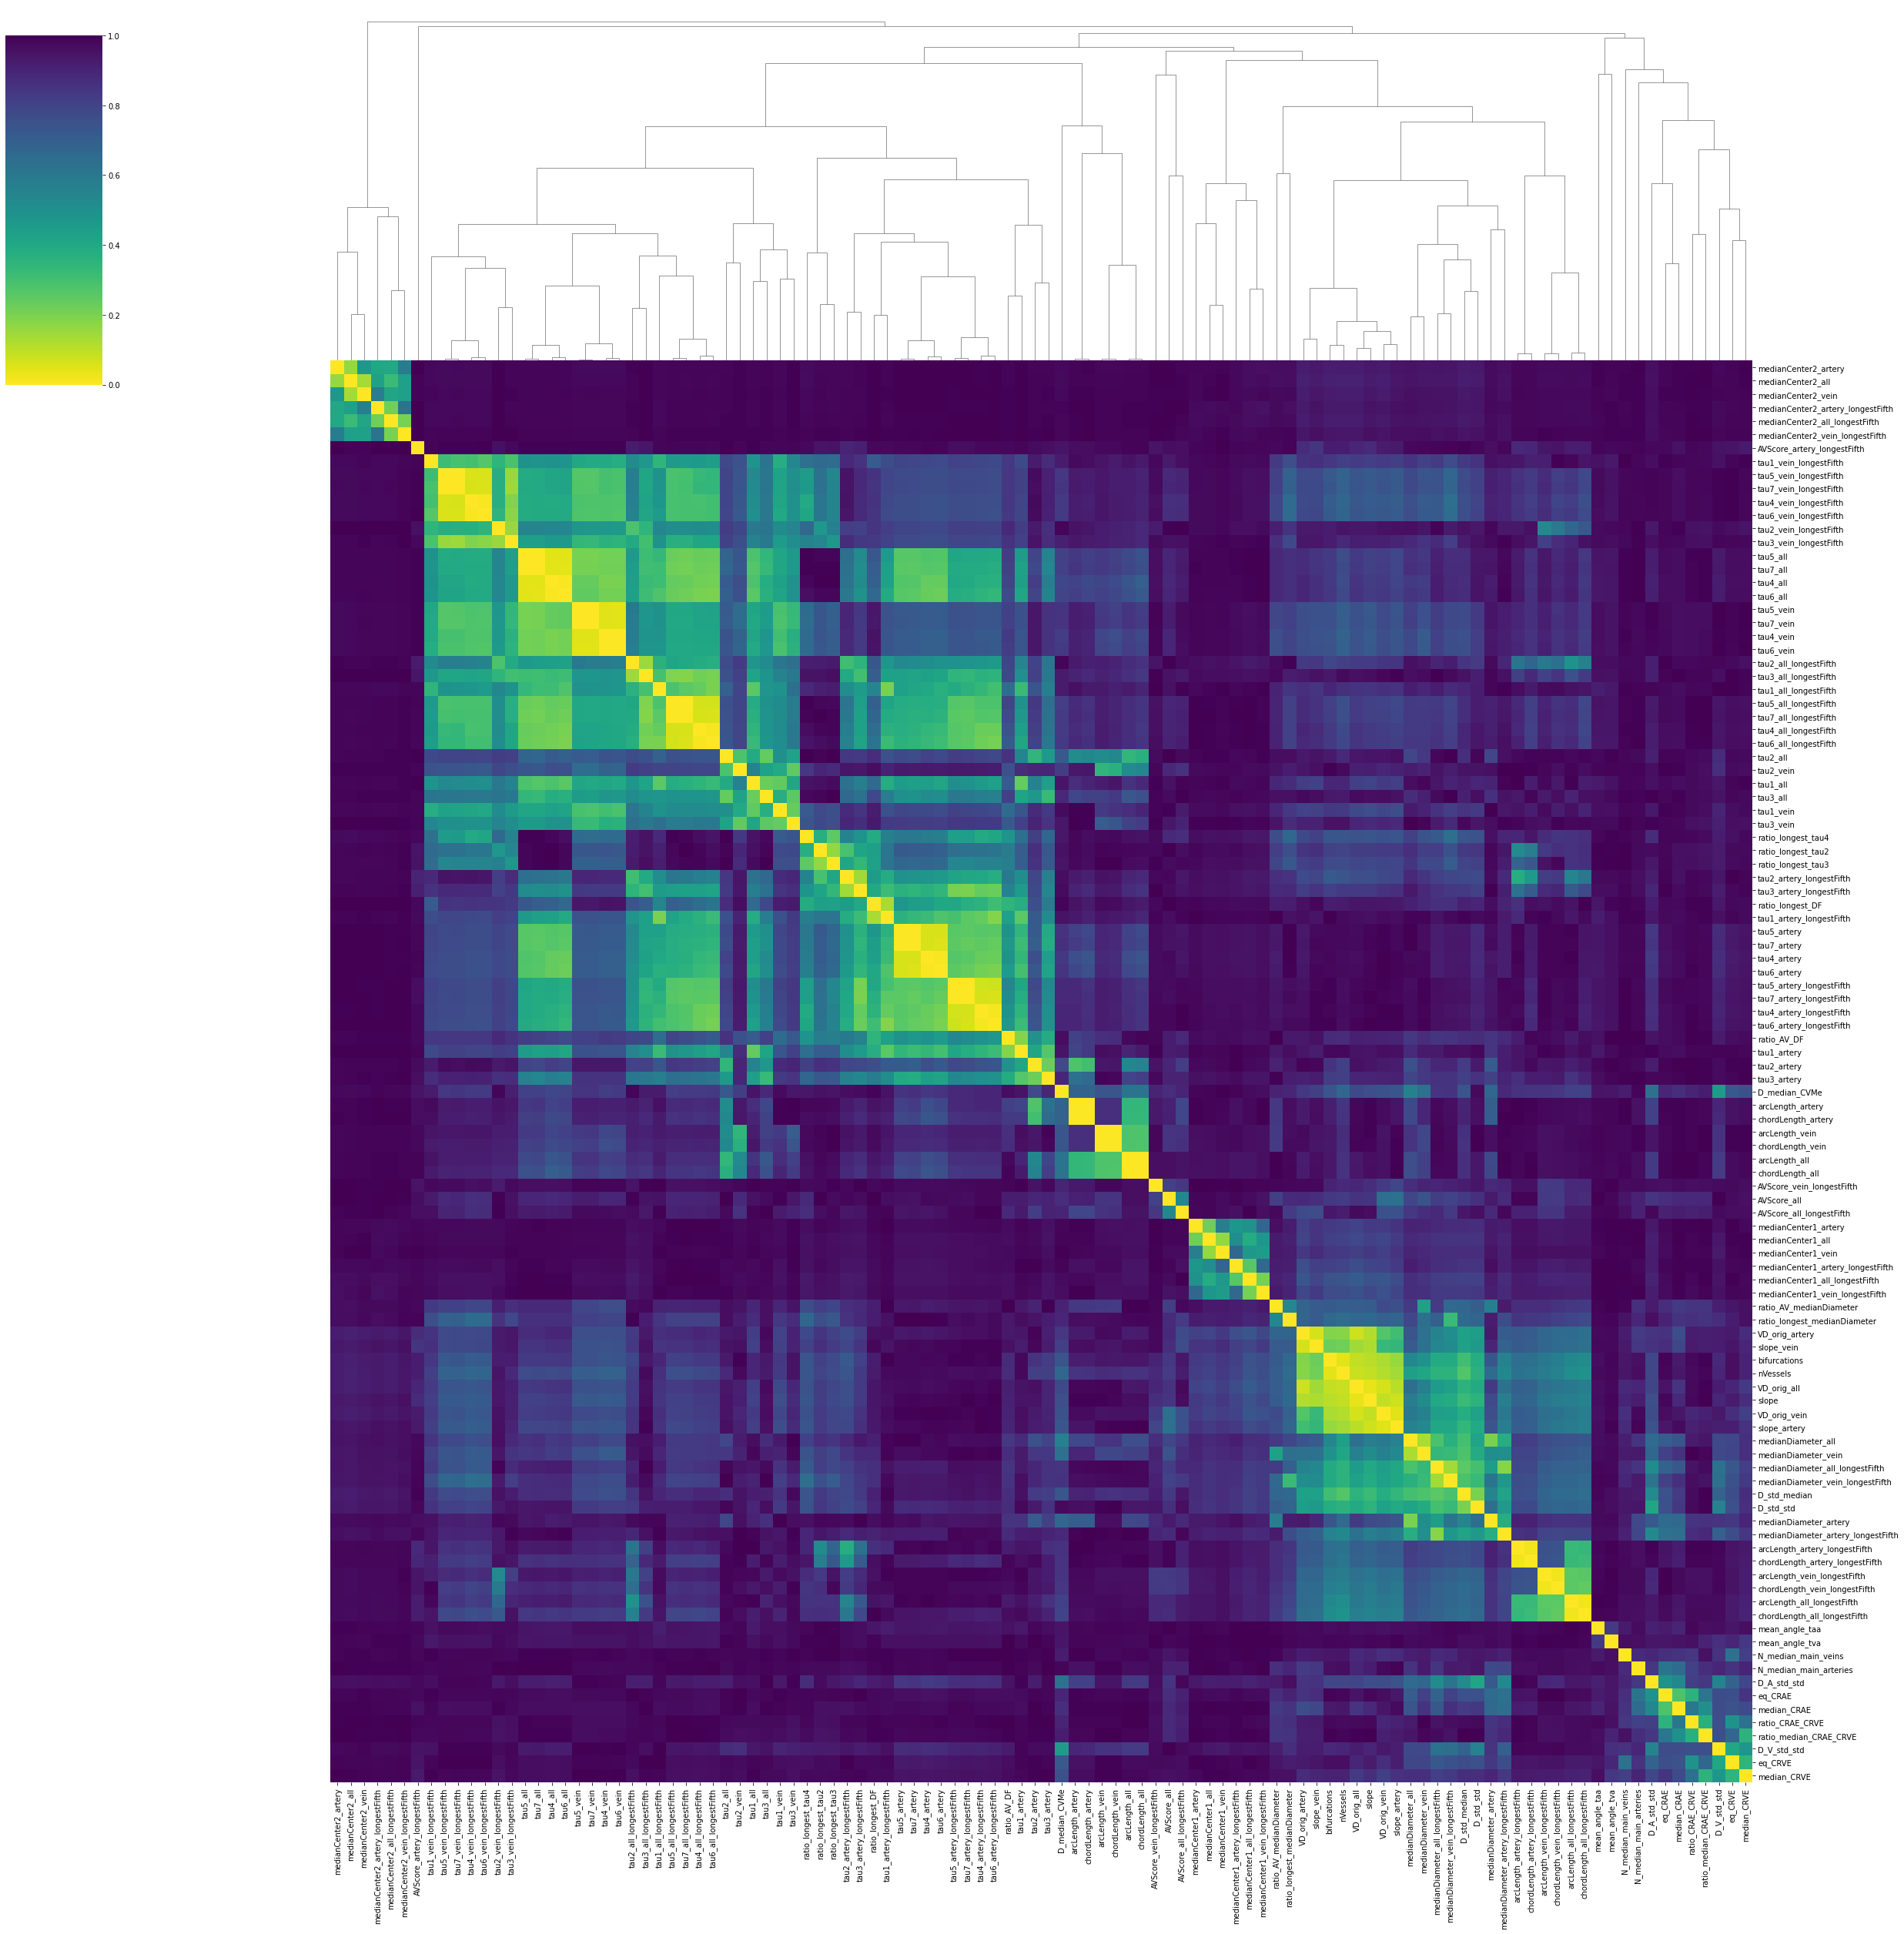

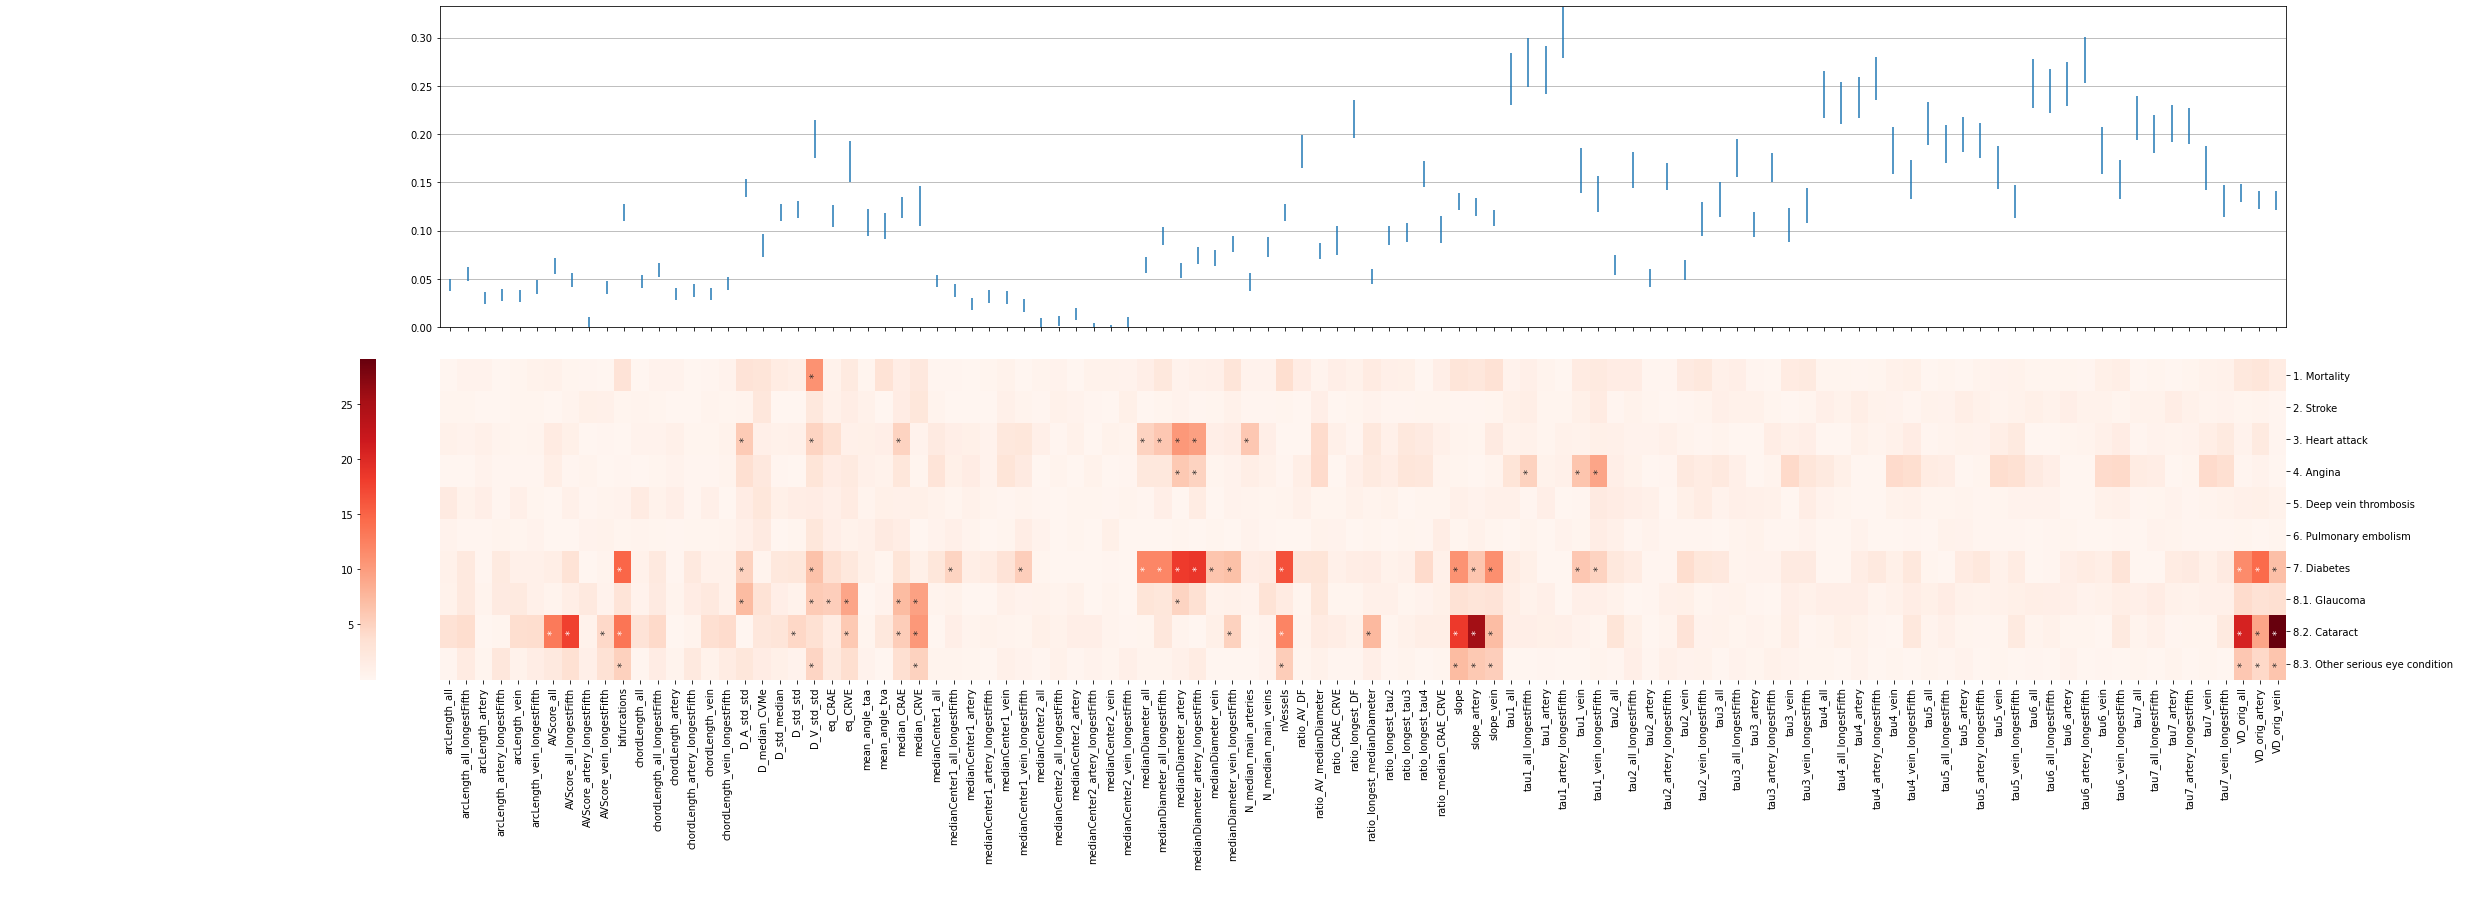

In [130]:
# A: Clustermap


figsize=35

# traits['FUN'] = -traits['VD_orig_all']
# usedtraits=traits.columns#cluster_traits


import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
# # 1) no type specificity, no longest
# usedtraits=['tau1_all','tau2_all','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all', 'medianCenter1_all', 'medianCenter2_all']

# # 2) add type specificity
# usedtraits=['tau1_all','tau1_artery','tau1_vein','tau2_all','tau2_artery','tau2_vein','tau4_artery','tau4_vein','tau4_all','bifurcations','slope','VD_orig_all', 'AVScore_all',\
#             'eq_CRAE', 'eq_CRVE', 'ratio_CRAE_CRVE', 'mean_angle_taa', 'mean_angle_tva',\
#            'D_A_std_std', 'D_V_std_std', 'medianDiameter_all','medianDiameter_artery','medianDiameter_vein',\
#             'medianCenter1_all','medianCenter1_artery','medianCenter1_vein', 'medianCenter2_all',\
#             'medianCenter2_artery','medianCenter2_vein']
# print(usedtraits)

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
hc.cophenet(linkage, sp.distance.squareform(DF_dism))

h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(figsize,figsize), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)

plt.savefig(outfile1)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
order = h.dendrogram_row.reordered_ind
order = sorted(usedtraits, key=str.casefold)

ldsc = ldsc_full.loc[order]
cox = cox_full[order]

#### B: HERITABILITY

fig, axs = plt.subplots(nrows=3, figsize=(figsize,13), gridspec_kw={'height_ratios': [50, 50, 30]})

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
h_h2=axs[0].errorbar(ldsc.index, ldsc['h2'], ldsc['h2_se'], fmt='', linestyle='')
axs[0].grid(axis='y')
axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
axs[0].set(xticklabels=[])
axs[0].margins(x=0.005*40/figsize)

plt.tight_layout() # needed to match x-axis later

#### C: DISEASE


# Bonferroni Cox significance asterisks


# significant = cox > -np.log10(0.05 / cox.shape[0] / cox.shape[1])

# asterisks = significant.applymap(str)
# asterisks = asterisks.replace('False', "")
# asterisks = asterisks.replace('True', "*")

# significant = cox > -np.log10(0.01 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "**")
# asterisks[significant] = tmp[significant]

# significant = cox > -np.log10(0.001 / cox.shape[0] / cox.shape[1])
# tmp = significant.applymap(str)
# tmp = tmp.replace('False', "")
# tmp = tmp.replace('True', "***")
# asterisks[significant] = tmp[significant]


# Benjamini-Hochberg significant


cox_melt = pd.melt(cox.reset_index(), id_vars='index')
cox_melt['rank'] = cox_melt['value'].rank()
cox_melt['bh_threshold'] = -np.log10(0.05 / cox_melt['rank'])
cox_melt['significant'] = cox_melt['value'] > cox_melt['bh_threshold']
significant = cox_melt.pivot(columns='variable', index='index')['significant']

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

asterisks = asterisks[order]



# plot cox heatmap

h_cox=sns.heatmap(data=cox, ax=axs[1], annot=asterisks, fmt='', annot_kws={'rotation': 90}, cbar_kws={'location':'left'}, cmap='Reds')
axs[1].tick_params(axis='y', rotation=0)
axs[1].yaxis.tick_right()


# plt.tight_layout() # needed to match x-axis later


# adjust plot position on X to match cluster

# originals
pos=axs[0].get_position().get_points()
pos_cluster=h.ax_heatmap.get_position().get_points()

# adapt to cluster
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]

# create adjusted bbox object
bbox=axs[0].get_position()
bbox.set_points(pos)

# adapt plot
axs[0].set_position(bbox)


pos=h_cox.get_position().get_points()
pos[0][0] = pos_cluster[0][0]
pos[1][0] = pos_cluster[1][0]
bbox=h_cox.get_position()
bbox.set_points(pos)
axs[1].set_position(bbox)

axs[2].axis('off')
plt.savefig(outfile2)

### Hypothesis

1) Looking at only longest segments helps -> rarely
* tau2 heritability clearly profits, also medianDiameter_all
* but no distinct new disease associations